Libraries

In [1]:
#!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#!pip install scipy
import scipy
#!pip install seaborn
import seaborn as sns
#!pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GroupShuffleSplit
from sklearn import metrics

Data file (mean_with_labels.csv):
- json_position refers to position of base (of transcript read?)
- cols: transcript_name,json_position,nucleotide_seq,dwelling_time_min1,sd_min1,mean_min1,dwelling_time,sd,mean, dwelling_time_plus1,sd_plus1,mean_plus1,dwelling_time_merged,sd_merged,mean_merged,gene_id,label
- dwelling time, sd, mean separated into -1 position, 0, +1 positions accordingly, followed by merged, gene id, label
- each row in csv = the merged read for a transcript
- label = 0 for no modification, =1 for m6a modification at the position of the that transcript/gene (i think its the json position)

Logistic regression to predict probabilities of modification (class label = 1)
- no vectorization of non numeric variables

In [9]:
# read in data
data = pd.read_csv("mean_with_labels.csv")

# train test split of data (without vectorization)
# split by gene
x = data.drop('label', axis=1)
y = data.label

gss = GroupShuffleSplit(n_splits=2, random_state=0)
train_i, test_i = next(gss.split(x,y,groups=x.gene_id))

x_train = x.loc[train_i]
y_train = y.loc[train_i]

x_test = x.loc[test_i]
y_test = y.loc[test_i]

# train test split (without vectorization)
# training and testing

# drop following cols for x_train and x_test: transcript name, nucleotide seq, gene_id
x_train_final = x_train.drop(['transcript_name', 'nucleotide_seq', 'gene_id'], axis=1)
x_test_final = x_test.drop(['transcript_name', 'nucleotide_seq', 'gene_id'], axis=1)

# Logistic regression model
# instantiate
logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_train_final, y_train)

y_pred = logreg.predict(x_test_final)
y_pred_prob = logreg.predict_proba(x_test_final)

# note each element in y_pred_prob is a list of 2 elements, prob of row being 0 and prob of it being 1 respectively
pred_for_classes = pd.DataFrame(y_pred_prob, columns= ["no modification", "modified"])

# ROC curve
# note label =0 is no modification, =1 is modification
y_pred_m6a = pred_for_classes["modified"]
metrics.RocCurveDisplay.from_predictions(y_test, y_pred_m6a)
#plt.show()


In [ ]:
# classification_report

target_names = ['no m6a modification', 'm6a modification'] # labels 0, 1
print(classification_report(y_test, y_pred, target_names=target_names))

Vectorization attempts
- using TfidfVectorizer
- attempts vary in terms of n grams

Logistic regression to predict probabilities of modification (class label = 1)
- Unigram Vectorizing of nucleotide sequence

       no modification  modified
0             0.952007  0.047993
1             0.976975  0.023025
2             0.986271  0.013729
3             0.871295  0.128705
4             0.913513  0.086487
...                ...       ...
24294         0.997601  0.002399
24295         0.995306  0.004694
24296         0.995243  0.004757
24297         0.982460  0.017540
24298         0.990365  0.009635

[24299 rows x 2 columns]


c:\Users\yilin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


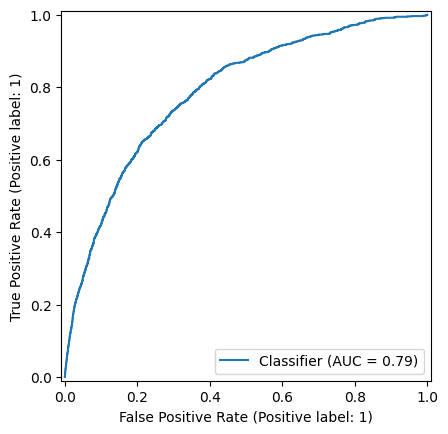

In [80]:
# attempt vectorizing
#1. n gram tfidf vectorizer

# using only unigrams
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = ['A', 'T', 'C', 'G']
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1,1)).fit(corpus)
#print(vectorizer.vocabulary_)

data = pd.read_csv("mean_with_labels.csv")

# split by gene
v_nucleotide_seq = vectorizer.transform(data["nucleotide_seq"])
#print(v_nucleotide_seq)
#df = data.assign(v_seq = v_nucleotide_seq)
v = pd.DataFrame(scipy.sparse.csr_matrix.toarray(v_nucleotide_seq))
#print(v)
#print(v[0]) #refers to the first col
new_nucleotide_data = {'s0':v[0], "s1": v[1], "s2":v[2], "s3":v[3]}
df = data.assign(**new_nucleotide_data)
#print(df.head)

x = df.drop('label', axis=1)

y = df.label

gss = GroupShuffleSplit(n_splits=2, random_state=0)
train_i, test_i = next(gss.split(x,y,groups=x.gene_id))

x_train = x.loc[train_i]
y_train = y.loc[train_i]

x_test = x.loc[test_i]
y_test = y.loc[test_i]

# drop following cols for x_train and x_test: transcript name, nucleotide seq, gene_id

x_train_final = x_train.drop(['transcript_name', 'nucleotide_seq', 'gene_id'], axis=1)
x_test_final = x_test.drop(['transcript_name', 'nucleotide_seq', 'gene_id'], axis=1)

#print(x_train_final.columns)
#print(x_test_final.columns)

# Logistic regression model

# instantiate
logreg = LogisticRegression(max_iter=1000)

#logreg.fit(x_train.loc[:, ["transcript_position", "dwelling_time_merged", "sd_merged", "mean_merged"]], y_train)
logreg.fit(x_train_final, y_train)

y_pred = logreg.predict(x_test_final)
y_pred_prob = logreg.predict_proba(x_test_final)

# note each element in y_pred_prob is a list of 2 elements, prob of row being 0 and prob of it being 1 respectively

#print(y_pred_prob[0])
pred_for_classes = pd.DataFrame(y_pred_prob, columns= ["no modification", "modified"])
print(pred_for_classes)

# note label =0 is no modification, =1 is modification
y_pred_m6a = pred_for_classes["modified"]
metrics.RocCurveDisplay.from_predictions(y_test, y_pred_m6a)
#plt.show()

In [81]:
# classification_report

target_names = ['no m6a modification', 'm6a modification'] # labels 0, 1
print(classification_report(y_test, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

no m6a modification       0.96      1.00      0.98     23221
   m6a modification       0.46      0.01      0.01      1078

           accuracy                           0.96     24299
          macro avg       0.71      0.50      0.49     24299
       weighted avg       0.93      0.96      0.93     24299



Logistic regression to predict probabilities of modification (class label = 1)
- Bigram Vectorizing of nucleotide sequence

       no modification  modified
0             0.942567  0.057433
1             0.992710  0.007290
2             0.986226  0.013774
3             0.961740  0.038260
4             0.810453  0.189547
...                ...       ...
24294         0.994770  0.005230
24295         0.997143  0.002857
24296         0.997216  0.002784
24297         0.979744  0.020256
24298         0.991016  0.008984

[24299 rows x 2 columns]


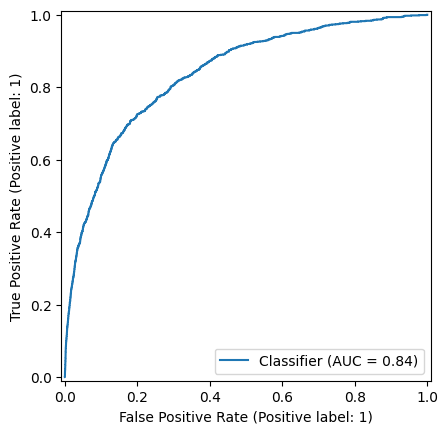

In [95]:
# attempt vectorization 
#1. using tfidf vectorizer

# using bigrams

from sklearn.feature_extraction.text import TfidfVectorizer
data = pd.read_csv("mean_with_labels.csv")
#print(data['nucleotide_seq'])
corpus = data['nucleotide_seq']
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2,2)).fit(corpus)
#print(vectorizer.vocabulary_)


# split by gene
v_nucleotide_seq = vectorizer.transform(data["nucleotide_seq"])
#print(v_nucleotide_seq)
#df = data.assign(v_seq = v_nucleotide_seq)
v = pd.DataFrame(scipy.sparse.csr_matrix.toarray(v_nucleotide_seq))
#print(v)
#print(v[0]) #refers to the first col
new_nucleotide_data = {'s0':v[0], "s1": v[1], "s2":v[2], "s3":v[3], "s4":v[4], "s5":v[5], "s6":v[6], "s7":v[7], "s8":v[8],
                       "s9":v[9], "s10":v[10], "s11":v[11], "s12":v[12], "s13":v[13], "s14":v[14]}
df = data.assign(**new_nucleotide_data)
#print(df.head)

x = df.drop('label', axis=1)

y = df.label

gss = GroupShuffleSplit(n_splits=2, random_state=0)
train_i, test_i = next(gss.split(x,y,groups=x.gene_id))

x_train = x.loc[train_i]
y_train = y.loc[train_i]

x_test = x.loc[test_i]
y_test = y.loc[test_i]

# drop following cols for x_train and x_test: transcript name, nucleotide seq, gene_id

x_train_final = x_train.drop(['transcript_name', 'nucleotide_seq', 'gene_id'], axis=1)
x_test_final = x_test.drop(['transcript_name', 'nucleotide_seq', 'gene_id'], axis=1)

#print(x_train_final.columns)
#print(x_test_final.columns)

# Logistic regression model

# instantiate
logreg = LogisticRegression(max_iter=10000)

#logreg.fit(x_train.loc[:, ["transcript_position", "dwelling_time_merged", "sd_merged", "mean_merged"]], y_train)
logreg.fit(x_train_final, y_train)

y_pred = logreg.predict(x_test_final)
y_pred_prob = logreg.predict_proba(x_test_final)

# note each element in y_pred_prob is a list of 2 elements, prob of row being 0 and prob of it being 1 respectively

#print(y_pred_prob[0])
pred_for_classes = pd.DataFrame(y_pred_prob, columns= ["no modification", "modified"])
print(pred_for_classes)

# note label =0 is no modification, =1 is modification
y_pred_m6a = pred_for_classes["modified"]
metrics.RocCurveDisplay.from_predictions(y_test, y_pred_m6a)
#plt.show()


In [96]:
# print(classification_report(y_test, y_pred))

target_names = ['no m6a modification', 'm6a modification'] # labels 0, 1
print(classification_report(y_test, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

no m6a modification       0.96      1.00      0.98     23221
   m6a modification       0.60      0.06      0.11      1078

           accuracy                           0.96     24299
          macro avg       0.78      0.53      0.54     24299
       weighted avg       0.94      0.96      0.94     24299



Logistic regression to predict probabilities of modification (class label = 1)
- Trigram Vectorizing of nucleotide sequence

{'atg': 9, 'tga': 33, 'gac': 25, 'acc': 4, 'ccc': 15, 'ctg': 22, 'act': 5, 'gga': 27, 'gaa': 24, 'aac': 1, 'cct': 17, 'taa': 31, 'aaa': 0, 'gag': 26, 'aga': 6, 'ccg': 16, 'cgg': 19, 'aca': 3, 'cac': 11, 'cag': 12, 'cta': 20, 'aag': 2, 'cat': 13, 'cga': 18, 'agg': 7, 'cca': 14, 'gtg': 30, 'ggg': 28, 'ctc': 21, 'tgg': 34, 'ttg': 36, 'caa': 10, 'gta': 29, 'ctt': 23, 'ata': 8, 'tta': 35, 'tag': 32}


c:\Users\yilin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


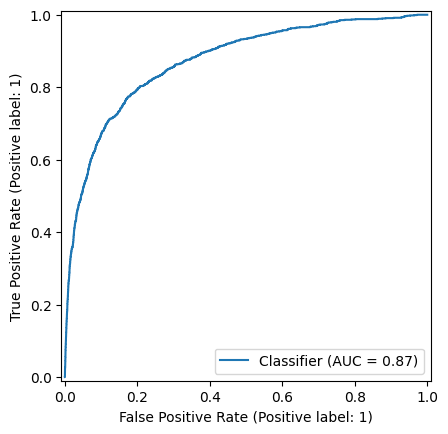

In [98]:
# attempt vectorization 2
#2. using tfidf vectorizer

# using 3 grams

# attempt vectorization 
#1. using tfidf vectorizer

# using bigrams

from sklearn.feature_extraction.text import TfidfVectorizer
data = pd.read_csv("mean_with_labels.csv")
#print(data['nucleotide_seq'])
corpus = data['nucleotide_seq']
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3,3)).fit(corpus)
#print(vectorizer.vocabulary_)


# split by gene
v_nucleotide_seq = vectorizer.transform(data["nucleotide_seq"])
#print(v_nucleotide_seq)
#df = data.assign(v_seq = v_nucleotide_seq)
v = pd.DataFrame(scipy.sparse.csr_matrix.toarray(v_nucleotide_seq))
#print(v)
#print(v[0]) #refers to the first col
new_nucleotide_data = {'s0':v[0], "s1": v[1], "s2":v[2], "s3":v[3], "s4":v[4], "s5":v[5], "s6":v[6], "s7":v[7], "s8":v[8],
                       "s9":v[9], "s10":v[10], "s11":v[11], "s12":v[12], "s13":v[13], "s14":v[14], "s15":v[15],
                       "s16":v[16], "s17":v[17], "s18":v[18], "s19":v[19], "s20":v[20], "s21":v[21], "s22":v[22],
                       "s23":v[23], "s24":v[24], "s25":v[25], "s26":v[26], "s27":v[27], "s28":v[28], "s29":v[29],
                       "s30":v[30], "s31":v[31], "s32":v[32], "s33":v[33], "s34":v[34], "s35":v[35], "s36":v[36]}
df = data.assign(**new_nucleotide_data)
#print(df.head)

x = df.drop('label', axis=1)

y = df.label

gss = GroupShuffleSplit(n_splits=2, random_state=0)
train_i, test_i = next(gss.split(x,y,groups=x.gene_id))

x_train = x.loc[train_i]
y_train = y.loc[train_i]

x_test = x.loc[test_i]
y_test = y.loc[test_i]

# drop following cols for x_train and x_test: transcript name, nucleotide seq, gene_id

x_train_final = x_train.drop(['transcript_name', 'nucleotide_seq', 'gene_id'], axis=1)
x_test_final = x_test.drop(['transcript_name', 'nucleotide_seq', 'gene_id'], axis=1)

#print(x_train_final.columns)
#print(x_test_final.columns)

# Logistic regression model

# instantiate
logreg = LogisticRegression(max_iter=100000)

#logreg.fit(x_train.loc[:, ["transcript_position", "dwelling_time_merged", "sd_merged", "mean_merged"]], y_train)
logreg.fit(x_train_final, y_train)

y_pred = logreg.predict(x_test_final)
y_pred_prob = logreg.predict_proba(x_test_final)

# note each element in y_pred_prob is a list of 2 elements, prob of row being 0 and prob of it being 1 respectively

#print(y_pred_prob[0])
pred_for_classes = pd.DataFrame(y_pred_prob, columns= ["no modification", "modified"])
#print(pred_for_classes)

# note label =0 is no modification, =1 is modification
y_pred_m6a = pred_for_classes["modified"]
metrics.RocCurveDisplay.from_predictions(y_test, y_pred_m6a)
#plt.show()

In [100]:
# print(classification_report(y_test, y_pred))

target_names = ['no m6a modification', 'm6a modification'] # labels 0, 1
print(classification_report(y_test, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

no m6a modification       0.96      0.99      0.98     23221
   m6a modification       0.59      0.17      0.27      1078

           accuracy                           0.96     24299
          macro avg       0.78      0.58      0.62     24299
       weighted avg       0.95      0.96      0.95     24299

